# Tutorial

## Relevant imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

import pyforfluids as pff
import chemicals

import warnings

# Sometimes we go through irreal points 
warnings.filterwarnings(
        action="ignore",
        category=RuntimeWarning,
        module="numpy"
)

cmap = matplotlib.cm.get_cmap('inferno')

## Definition of the model to be used

In [2]:
model = pff.models.GERG2008()

## Fluid's initial state

In [3]:
temperature = 250  # Degrees Kelvin
density = 1  # mol/L
pressure = 101325  # Pa
composition = {'methane': 0.9, 'ethane': 0.05, 'propane': 0.05}  # Molar fractions

### Definition of the fluid
The properties will be calculated at the moment of the object definition.

In [4]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    density=density
)

#### Pressure as an init variable
Pressure can be used as an initial variable, in this case the method `fluid.density_iterator` will be called internally to find the root of density at the given pressure, since all models use density as an independent variable instead of temperature. 

This can lead to trouble since multiple roots can be obtained in the equilibrium region!

In [5]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    pressure=pressure
)

### Accessing properties

Properties are stored in the Fluid attribute `Fluid.properties` as a dictionary, they can either be accessed that way or by calling them directly from the fluid.

All the properties are expressed in **International System** units, except for density that's expressed in **[mol/L]**

In [6]:
fluid.properties

critical_density                                                          9.442773
critical_temperature                                                    207.106811
ideal_helmholtz                  [[-1.4648338367393778, 0.0, 0.0], [192.9025895...
residual_helmholtz               [[-0.004185073700756314, 0.0, 0.0], [-0.806509...
ar_x                             [-0.0041889410624157, 0.0, 0.0, -0.00416396025...
ar_dx                            [-0.8072744747399465, 0.0, 0.0, -0.80225571856...
ar_tx                            [-0.0108604494306309, 0.0, 0.0, -0.01160250616...
ar_xx                            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dvr_dx                           [0.20451237337230468, 0.0, 0.0, 0.250642937311...
dtr_dx                           [397.89662106931627, 0.0, 0.0, 521.78975121897...
dvr2_dx2                         [0.19725144473637551, 0.17882849453231878, 0.1...
dtr2_dx2                         [381.128, 252.384, 608.2564, 595.7192391305018...
dvr2

In [7]:
fluid['isochoric_heat']

28.14582568798458

### State changes

A fluid thermodynamic variable can be changed by using the methods:

- `Fluid.set_temperature`
- `Fluid.set_composition`
- `Fluid.set_density`
- `Fluid.set_pressure`

When a property is changed, the properties are not re-calculated, so it's a **must** to call the method `Fluid.calculate_properties`. This is intended to avoid useless calculations if two or more variables are to be changed. In the case of a pressure change `Fluid.density_iterator` will be called!

In [8]:
fluid.set_temperature(280)
fluid.set_density(2)

fluid.calculate_properties()

In [9]:
fluid['isochoric_heat']

30.65088482829082

## Calculating isotherms

Isotherms at the fluid temperature can be calculated along a density range with the method `Fluid.isotherm`. This will return a dictionary equivalent to the `Fluid.properties` one, but each value will be a list instead of a single value.

In [10]:
density_range = np.linspace(1e-5, 20, 100)
isotherm = fluid.isotherm(density_range)

isotherm["enthalpy"]

0     -689.874337
1     -793.645967
2     -896.476853
3     -998.330528
4    -1099.176415
         ...     
95   -5323.723695
96   -5275.307585
97   -5222.196993
98   -5164.233932
99   -5101.257637
Name: enthalpy, Length: 100, dtype: float64

In [11]:
isotherm['pressure'][:5]

0    2.328051e+01
1    4.640928e+05
2    9.159225e+05
3    1.355890e+06
4    1.784383e+06
Name: pressure, dtype: float64

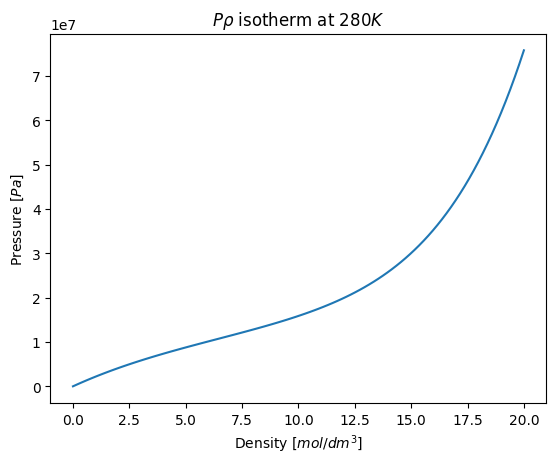

In [12]:
plt.title(r'$P\rho$ isotherm at 280$K$')

plt.plot(density_range, isotherm['pressure'])
plt.ylabel(r"Pressure [$Pa$]")
plt.xlabel(r"Density [$mol/dm^3$]")
plt.savefig("isotherm.png")
plt.show()

Calculating multiple isotherms over the same density range

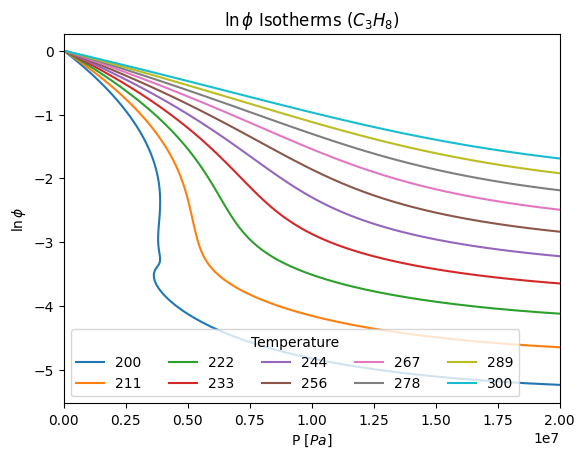

In [13]:
for temperature in np.linspace(200, 300, 10):

    fluid.set_temperature(temperature)
    isotherm = fluid.isotherm(density_range)
    
    # Propane is the 5th compound in the 
    # GERG2008 model
    plt.plot(
        isotherm["pressure"],
        isotherm["lnfug"].apply(lambda x: x[4]),
        label=round(temperature)
    )

plt.title(r"$\ln \phi$ Isotherms ($C_3H_8$)")
plt.legend(title="Temperature", ncol=5)
plt.xlabel(r"P [$Pa$]")
plt.ylabel(r"$\ln \phi$")
plt.xlim(0, 2e7)
plt.savefig("lnfug.png")


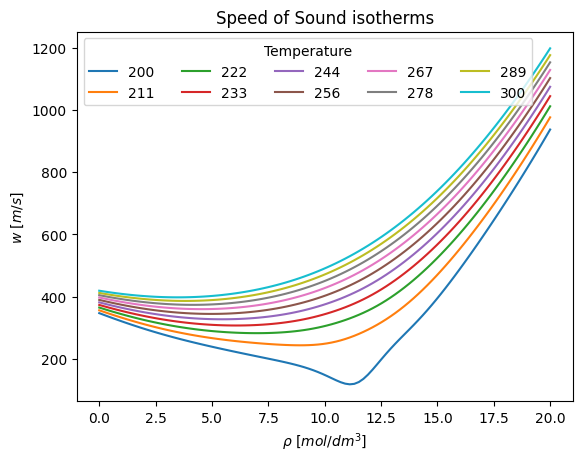

In [14]:
for temperature in np.linspace(200, 300, 10):

    fluid.set_temperature(temperature)
    isotherm = fluid.isotherm(density_range)
    
    # Propane is the 5th compound in the 
    # GERG2008 model
    plt.plot(
        isotherm["density"],
        isotherm["sound_speed"],
        label=round(temperature)
    )

plt.title(r"Speed of Sound isotherms")
plt.legend(title="Temperature", ncol=5)
plt.xlabel(r"$\rho\ [mol/dm^3]$")
plt.ylabel(r"$w\ [m/s]$")
plt.savefig("ss.png")


## Equilibrium

PyForFluids provides a set of equilibrium calculation procedures (like PT Flash) in it's `pyforfluids.equilibrium` module.

### Flash PT
Biphasic flash PT calculations are made using the Michelsen's consecutive substitutions method.

In [15]:
flash_pt = pff.equilibrium.flash_pt

composition = {'propane': 0.01, 'butane': 0.5, 'isobutane': 0.15, 
               'pentane': 0.2, 'hexane': 0.14}
temperature = 366.48
pressure = 1.039e6

fluid = pff.Fluid(
    model=pff.models.GERG2008(),
    composition=composition,
    temperature=temperature,
    density=1,
)

vapor, liquid, beta, it = flash_pt(fluid, pressure, temperature)

In [16]:
vapor

Fluid(model=GERG2008, temperature=366.48, pressure=1039000.0000, density=0.4236, composition={'propane': 0.02405919, 'butane': 0.59222959, 'isobutane': 0.22051554, 'pentane': 0.11992022, 'hexane': 0.04327129})

In [17]:
liquid

Fluid(model=GERG2008, temperature=366.48, pressure=1039000.0000, density=7.7999, composition={'propane': 0.00892179, 'butane': 0.49292686, 'isobutane': 0.14459213, 'pentane': 0.20614136, 'hexane': 0.14741818})

In [18]:
beta

0.07122802734375

Running sucessive flashes along pressure and temperature ranges

In [19]:
vapors = {}
liquids = {}
betas = {}
temperatures = np.linspace(350, 380, 5)
pressures = np.linspace(0.4e6, 1.5e6, 49)

for t in temperatures:
    vapors[t] = []
    liquids[t] = []
    betas[t] = []
    
    for p in pressures:
        vapor, liquid, beta, it = flash_pt(fluid, p, t, rtol=1e-10, iterations=5)
        
        vapors[t].append(vapor)
        liquids[t].append(liquid)
        betas[t].append(beta)


In [ ]:
for t in temperatures:
    plt.plot(pressures, betas[t], label=t)

plt.legend(title="Temperature")
plt.xlabel(r"Pressure [$Pa$]")
plt.ylabel(r"Vapor fraction ($\beta$)")
plt.title("Vapor phase fraction")
plt.savefig("beta.png")
plt.show()

In [ ]:
# Extracting propane compositions along the flashes
component = "propane"
for i, t in enumerate(temperatures):
    ys = [vapor.composition[component] for vapor in vapors[t]]
    xs = [liquid.composition[component] for liquid in liquids[t]]
    idelx = np.where(np.diff(xs) < 0)[0][0]
    idely = np.where(np.diff(ys) < 0)[0][0]
    xs[idelx] = np.nan
    ys[idely] = np.nan
    plt.plot(pressures, xs, label=t, color=cmap(i * 50))
    plt.plot(pressures, ys, color=cmap(i*50))

plt.legend()
plt.title(r"$C_3H_8$ compositions")
plt.ylabel("Molar Fraction")
plt.xlabel(r"Pressure [$Pa$]")
plt.savefig("flashes.png")
plt.show()

## Cubic Equations of State

The given cubic equations of state are used with the `pyforfluids.models.CubicEOS` model, it calls Fortran routines based on the given parameters using an inner selector.

In [ ]:
# Using chemicals library to get pure compound properties
pc = []
tc = []
w = []
z = []
names = []

for component in composition:
    chem = chemicals.CAS_from_any(component)
    tc.append(chemicals.Tc(chem))
    pc.append(chemicals.Pc(chem)/1e5)
    w.append(chemicals.acentric.omega(chem))
    z.append(composition[component])
    names.append(component)

In [ ]:
pff.models.GERG2008()

In [ ]:
pr = pff.models.CubicEOS(
    model="PR",
    mix_rule="ClassicVdW",
    names=names,
    critical_temperature=tc,
    critical_pressure=pc,
    acentric_factor=w,
    kij_matrix=np.zeros((5,5)),
    lij_matrix=0*np.zeros((5,5))
)

In [ ]:
pr_fluid = fluid.copy(model=pr)

In [ ]:
pr_vapor, pr_liquid, prbeta, it = flash_pt(pr_fluid, pressure, temperature)

In [ ]:
pr_vapor

In [ ]:
pr_liquid, liquid

In [13]:
pressure = 4.56*1e6
fluid = pff.Fluid(
    model=pff.models.GERG2008(),
    composition={"methane": 0.13, "hydrogen_sulfide": 0.87},
    temperature=190,
    pressure=4.56*1e6
)

/home/fedebenelli/docs/programming/python/virtualenvs/gtf/pff/lib/python3.10/site-packages/pyforfluids/core.py:184: UserWarning: Two roots were found! Vapor-phase value will be used
  warnings.warn(


In [14]:
fluid.density_iterator(pressure)

(10.064485761655323, 27.82170179164212, False)

In [23]:
iso = fluid.isotherm(np.linspace(0.001, 30, 100))

(-22800000.0, 45600000.0)

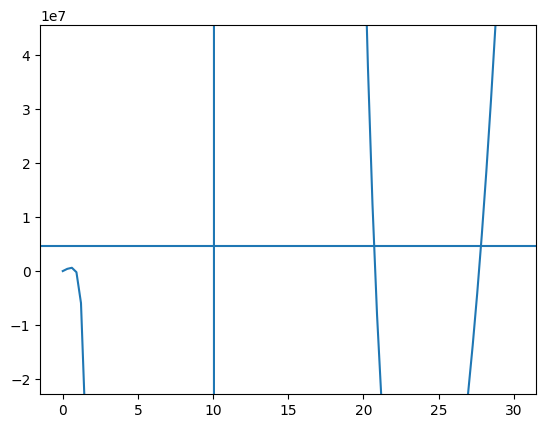

In [24]:
plt.axhline(4.56*1e6)
plt.plot(
    iso["density"],
    iso["pressure"]
)
plt.ylim(-pressure*5, pressure*10)